In [1]:
### Building Chatbot With Multiple Tools Using Langgraph
### Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [4]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [8]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [9]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [10]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [11]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\Win 11\AppData\Local\Temp\ipykernel_1232\637379855.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [12]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'The Latest AI News and AI Breakthroughs that Matter Most',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': "Wondering what's happening in the AI world?Here are the latest AI breakthroughs and newsthat are shaping the world around us!",
  'score': 0.98577},
 {'title': 'AI round-up: Week of March 3, 2025 - Akhia',
  'url': 'https://www.akhia.com/insights/benthinking/ai-round-up-week-of-march-03-2025',
  'content': "Exploring the latest in AI advancements and ethical challenges, from Google's AI-only search to new AI models and the implications of unfiltered AI.",
  'score': 0.98505},
 {'title': 'AI Weekly Digest - March 3 2025 - LinkedIn',
  'url': 'https://www.linkedin.com/pulse/ai-weekly-digest-march-3-2025-pa-media-ddmie',
  'content': 'NMA chief backs report on AI and copyright law. News Media Association chief executive Owen Meredith welcomed a report on AI and copyright',
  'score': 0.98171},
 {'title': 'GPT 4.5 is out! — Weekly AI News

In [13]:
### Combine all the tools in the list
tools=[arxiv,wiki,tavily]

In [14]:
## Initialize my LLM model
from langchain.chat_models import init_chat_model
llm=init_chat_model(model="openai:gpt-3.5-turbo")
llm_with_tools=llm.bind_tools(tools)

In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2EBH8A0Ivyc2dMgib1MboBSt', 'function': {'arguments': '{"query":"recent AI News"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 222, 'total_tokens': 242, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CMSZ7zjTDzISO8LPyetX0ZMwFKmfb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--08daa41e-3a0f-4ad3-9116-453005d8c105-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI News'}, 'id': 'call_2EBH8A0Ivyc2dMgib1MboBSt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 222, 'output_tokens': 20, 'total_tokens

In [16]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': 'call_Lnt6qrPaYPGSuKE8lgh5q9ya',
  'type': 'tool_call'}]

In [17]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

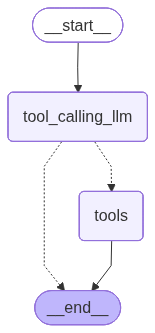

In [19]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools\n",
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END\n",
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_GSpvUIdpltI9xkYW61fvZH9m)
 Call ID: call_GSpvUIdpltI9xkYW61fvZH9m
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [21]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_KrdOP0bmcmKa2mpdOxBSBK5W)
 Call ID: call_KrdOP0bmcmKa2mpdOxBSBK5W
  Args:
    query: top 10 recent AI news for March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI INTELLIGENCE | Weekly Top 10 (3/14/25)", "url": "https://dwealth.news/2025/03/ai-intelligence-weekly-top-10-3-14-25/", "content": "TheAI Intelligence Weekly Top 10column presents the most viral topics in artificial intelligence for the week of 3/14/25.", "score": 0.98519}, {"title": "Top 5 AI trends in March 2025: AI agents, smarter supply ... - Neudesic", "url": "https://www.neudesic.com/blog/top-5-ai-trends-march-2025/", "content": "1. OpenAI Releases New Tools for Buildi

In [22]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_m3DQ2bjf5BFQyt929ly6IErr)
 Call ID: call_m3DQ2bjf5BFQyt929ly6IErr
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
